In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import random
import requests
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [3]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform = ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:01<00:00, 14236395.30it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 277568.25it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5105409.18it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14337501.32it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform= None
)

In [5]:
test_data.data.shape , train_data.data.shape

(torch.Size([10000, 28, 28]), torch.Size([60000, 28, 28]))

In [6]:
class_label = train_data.class_to_idx
class_label

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
class_name = train_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

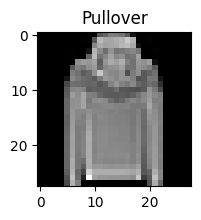

In [8]:
# torch.manual_seed(42)
n = random.randint(0,len(train_data),)
image, label = train_data[n]
plt.figure(figsize=(2,2))

plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_name[label])
plt.show()

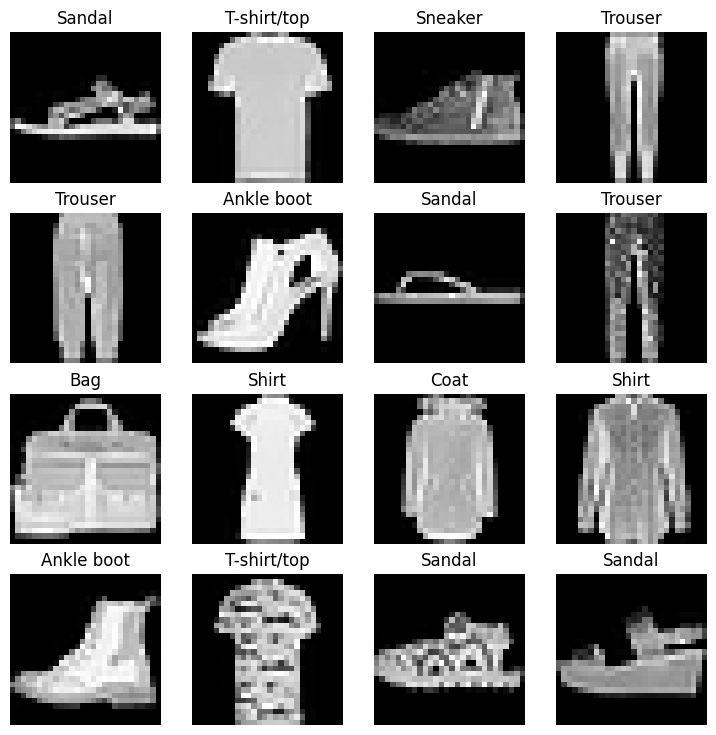

In [9]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
row,col = 4,4

for i in range(1,row*col+1):
  # print(i)
  random_idx = torch.randint(0,len(train_data),size=[1]).item()
  img , label = train_data[random_idx]
  fig.add_subplot(row,col,i)
  plt.imshow(img.squeeze(),cmap='gray')
  plt.title(class_name[label])
  plt.axis(False)

In [10]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size= BATCH_SIZE,
                              shuffle= True,
                  )

test_dataloader = DataLoader(test_data,
                             batch_size =BATCH_SIZE,
                             shuffle = False
                  )

In [11]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [12]:
next(iter(train_dataloader))[0].shape

torch.Size([32, 1, 28, 28])

In [13]:
class FashionMNISTModelV2(nn.Module):

  def __init__(self,
               in_features:  int,
               out_features: int,
               hidden_units: int):
    """

    Args:
      in_features: number of channels
      out_features: number of labels
      hidden_units: number of hidden layers

    """

    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = in_features,out_channels= hidden_units,
                  kernel_size= 3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units, out_channels=hidden_units,
                  kernel_size= 3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=out_features,
                  kernel_size = 3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

                                  )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7,
                  out_features=out_features))

  def forward(self,x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x




In [14]:
model = FashionMNISTModelV2(1,10,10)

In [15]:
if Path('helper_functions.py').is_file():
  print('Already Downloaded')
else:
  re = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open ('helper_functions.py','wb') as f:
    f.write(re.content)

In [16]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr = 0.1)

In [17]:
def print_train_time(start: int,
                     end: int,
                     device: torch.device = None):
  print(f'train time in this {device} is {end - start:0.3f}')
  return end - start

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
torch.manual_seed(42)
train_start_time = timer()

EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):

  print(f"Epoch: ------ {epoch} ------")
  train_loss = 0
  train_accuracy = 0
  for batch , (X,y) in enumerate(train_dataloader):
    model.train()
    X,y = X.to(device),y.to(device)

    logit = model(X)

    loss = loss_fn(logit, y)
    acc = accuracy_fn(y, logit.argmax(dim=1))

    train_loss +=loss
    train_accuracy += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 ==0:
      print(f"Looked at {batch*len(X)} / {len(train_dataloader.dataset)}")
  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)

  model.eval()
  with torch.inference_mode():
    test_loss , test_accuracy = 0, 0

    for X_test,y_test in test_dataloader:
      X_test,y_test = X_test.to(device), y_test.to(device)

      test_pred = model(X_test)
      t_loss = loss_fn(test_pred,y_test)
      t_acc = accuracy_fn(y_test,test_pred.argmax(dim=1))

      test_loss += t_loss
      test_accuracy += t_acc

    test_loss /= len(test_dataloader)
    test_accuracy /= len(test_dataloader)

    print({f'Test Loss : {test_loss:0.3f}, Test Accuracy : {test_accuracy:0.3f}  | Train Loss : {train_loss:0.3f}, Train Accuracy : {train_accuracy:0.3f}'})


print('THE END!')
train_end_time = timer()

print(f"Train Time is {train_end_time - train_start_time}")






  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: ------ 0 ------
Looked at 0 / 60000
Looked at 12800 / 60000
Looked at 25600 / 60000
Looked at 38400 / 60000
Looked at 51200 / 60000
{'Test Loss : 0.387, Test Accuracy : 86.072  | Train Loss : 0.603, Train Accuracy : 78.012'}
Epoch: ------ 1 ------
Looked at 0 / 60000
Looked at 12800 / 60000
Looked at 25600 / 60000
Looked at 38400 / 60000
Looked at 51200 / 60000
{'Test Loss : 0.332, Test Accuracy : 88.039  | Train Loss : 0.356, Train Accuracy : 87.160'}
Epoch: ------ 2 ------
Looked at 0 / 60000
Looked at 12800 / 60000
Looked at 25600 / 60000
Looked at 38400 / 60000
Looked at 51200 / 60000
{'Test Loss : 0.319, Test Accuracy : 88.878  | Train Loss : 0.322, Train Accuracy : 88.352'}
THE END!
Train Time is 188.79024186899997


In [20]:
torch.manual_seed(42)
def model_eval(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: str):
  loss,acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X= X.to(device)
      y= y.to(device)

      pred_y = model(X)
      loss_pred = loss_fn(pred_y,y)
      accuracy = accuracy_fn(y, pred_y.argmax(dim=1))

      loss +=loss_pred
      acc += accuracy
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {'model_name': model.__class__.__name__,
            'model_loss':loss.item(),
            'model_accuracy': acc}




In [21]:
model_eval(model,test_dataloader,
               loss_fn,accuracy_fn,device)

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3187534511089325,
 'model_accuracy': 88.87779552715655}

Save the Model

In [26]:
MODEL_PATH = Path('models')

MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = 'FashinMNIST.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

torch.save(obj = model.state_dict(),
           f = MODEL_SAVE_PATH)

In [27]:
loaded_model = FashionMNISTModelV2(in_features=1,
                                   hidden_units=10,
                                   out_features=10)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [29]:
loaded_result = model_eval(loaded_model,test_dataloader,loss_fn,accuracy_fn,device)
model_result = model_eval(model,test_dataloader,loss_fn,accuracy_fn,device)

In [30]:
torch.isclose(torch.tensor(model_result['model_loss']),
              torch.tensor(loaded_result['model_loss']))

tensor(True)